In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']]
static_au = static_au.div(static_au.max()).values

In [6]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
static_sd = df[['area','total_occupants','num_rooms']]
static_sd = static_sd.div(static_sd.max()).values

In [7]:
from sklearn.model_selection import train_test_split, KFold

In [8]:
n_splits = 10


In [9]:
from common import compute_rmse

In [10]:
np.arange(0.1, 1.0, 0.1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [11]:
COST_FUNCTIONS = ['penalty-sum-squares','penalty-sum-abs','penalty-count-nonzero']

In [72]:
out_A ={}
out_cost = {}
for cost_function in COST_FUNCTIONS:
    out_A[cost_function] = {}
    out_cost[cost_function] = {}
    for penalty_coeff in [1e-2, 1e-1, 0, 1, 10]:
        
        num_home=5
        H_known_Au = static_au
        H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, num_home, a, num_iter=1000, lr=1, dis=False, cost_function=cost_function, H_known=H_known_Au, penalty_coeff=penalty_coeff)
        HAT = multiply_case(H, A, T, case)
        mask = ~np.isnan(au_tensor)
        error = (HAT - au_tensor)[mask].flatten()
        
        
        print(cost_function, penalty_coeff, np.count_nonzero(A))
        out_A[cost_function][penalty_coeff] = A
        out_cost[cost_function][penalty_coeff] = np.sqrt((error ** 2).mean())

('penalty-sum-squares', 0.01, 65)
('penalty-sum-squares', 0.1, 65)
('penalty-sum-squares', 0, 60)
('penalty-sum-squares', 1, 70)
('penalty-sum-squares', 10, 66)
('penalty-sum-abs', 0.01, 61)
('penalty-sum-abs', 0.1, 59)
('penalty-sum-abs', 0, 60)
('penalty-sum-abs', 1, 68)
('penalty-sum-abs', 10, 68)
('penalty-count-nonzero', 0.01, 60)
('penalty-count-nonzero', 0.1, 60)
('penalty-count-nonzero', 0, 60)
('penalty-count-nonzero', 1, 60)
('penalty-count-nonzero', 10, 60)


In [41]:
out_zero = {}

for cost_function in COST_FUNCTIONS:
    out_zero[cost_function] = {}
    for penalty_coeff in [1e-2, 1e-1, 0, 1, 10]:
        
        out_zero[cost_function][penalty_coeff] = np.count_nonzero(out[cost_function][penalty_coeff])

In [53]:
t = out[cost_function][penalty_coeff]
np.sum(t>1e-3)

60

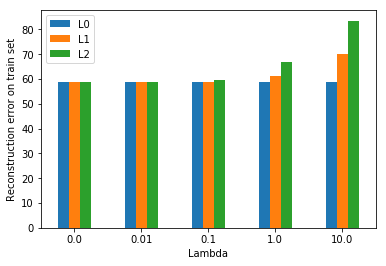

In [85]:
cost_df  = pd.DataFrame(out_cost)
cost_df.columns = ['L0','L1','L2']
cost_df.plot(kind='bar', rot=0)
plt.ylabel("Reconstruction error on train set")
plt.xlabel("Lambda")

In [65]:
out_lt = {}

for cost_function in COST_FUNCTIONS:
    out_lt[cost_function] = {}
    for penalty_coeff in [1e-2, 1e-1, 0, 1, 10]:
        t = out[cost_function][penalty_coeff]
        out_lt[cost_function][penalty_coeff] = np.sum(t>1e-2)

In [66]:
pd.DataFrame(out_zero).columns = ['L0','L1','L2']

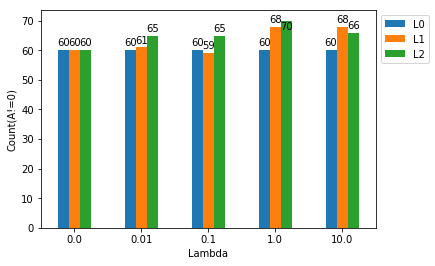

In [67]:
out
out_zero_df = pd.DataFrame(out_zero)
out_zero_df.columns = ['L0','L1','L2']
out_zero_df.plot(kind='bar', rot=0, stacked=False )
plt.ylabel("Count(A!=0)")
plt.xlabel("Lambda")
ax = plt.gca()
autolabel(ax.patches, plt.gca())
plt.legend(bbox_to_anchor=(1, 1))

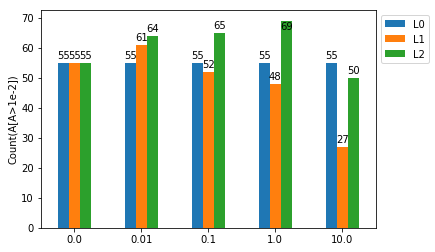

In [69]:
out_lt_df = pd.DataFrame(out_lt)
out_lt_df.columns = ['L0','L1','L2']
out_lt_df.plot(kind='bar', rot=0, stacked=False )

plt.ylabel("Count(A[A>1e-2])")
plt.xlabel("")
ax = plt.gca()
autolabel(ax.patches, plt.gca())
plt.legend(bbox_to_anchor=(1, 1))

In [17]:
print np.count_nonzero(A)
print np.count_nonzero(A1)
print np.count_nonzero(A2)

70
65
57


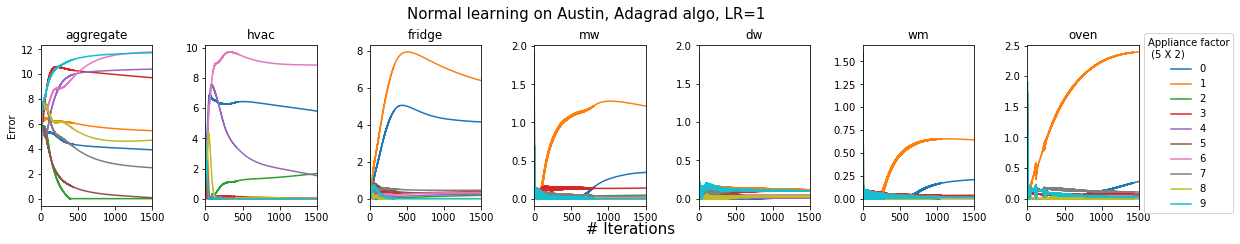

In [57]:
fig, ax = plt.subplots(ncols=7, figsize=(16, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    pd.DataFrame(np.array(As)[:, i,:,:].reshape(1500+1, num_home*a)).plot(ax=ax[i], title=appliance, legend=False)
plt.legend(bbox_to_anchor=(1., 1.1), title='Appliance factor\n (5 X 2)')
fig.tight_layout()
plt.suptitle('Normal learning on Austin, Adagrad algo, LR=1', y=1.05, fontsize=15)
fig.text(0.5, 0, '# Iterations', fontsize=15)
ax[0].set_ylabel("Error")

In [58]:
np.count_nonzero(A)

63

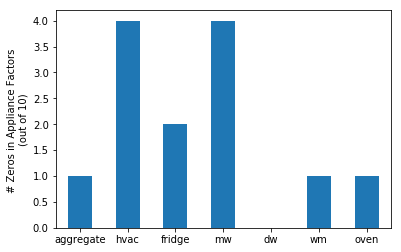

In [61]:
pd.Series((A2.reshape(7, 10)<1e-3).sum(axis=1), index=APPLIANCES_ORDER).plot(kind='bar', rot=0)
plt.ylabel("# Zeros in Appliance Factors \n(out of 10)")

In [48]:
pd.DataFrame(static_au).notnull().sum()

0    529
1    249
2    151
dtype: int64

In [51]:
pd.DataFrame(T2).plot()

NameError: name 'T2' is not defined

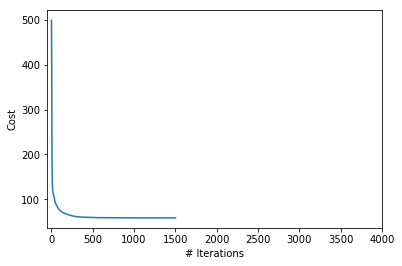

In [62]:
pd.Series(costs).plot()
plt.xlim((-50, n_iter))
plt.xlabel("# Iterations")
plt.ylabel("Cost")

In [19]:
H_au, A_au, T_au = learn_HAT_adagrad(case, au_tensor, num_home, a, num_iter=3200, lr=5, dis=True, cost_function=cost, H_known=H_known_Au)


901.031398359
62.5145262918
58.8038722897
58.5633392445
58.453768045
58.4056923894
58.5451629256


In [20]:
H_au, A_au, T_au = learn_HAT_adagrad(case, au_tensor, num_home, a, num_iter=3200, lr=1, dis=True, cost_function=cost, H_known=H_known_Au)


487.495956598
59.4167585332
58.6890430482
58.5895343872
58.5245989962
58.4700436351
58.4248908815


In [63]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 3
TRAIN_SPLITS = range(10, 110, 40)
case = 2
num_home = 5
n_iter=1200

cost = 'abs-penalty'
algo = 'adagrad'
for static_fac in ['static',None]:
    if static_fac is None:
        H_known_Au = None
        H_known_Sd = None
    else:
        H_known_Au = static_au
        H_known_Sd = static_sd
    np.random.seed(0)
    pred[static_fac] = {}
    #for lam in [1e-2, 100]:
    for lam in [1e-2, 1e-1, 1, 10, 100]:
        pred[static_fac][lam] = {}
        for a in range(2, 3):
            if static_fac is not None:
                H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, H_known=H_known_Au, penalty_coeff=lam)
            else:
                H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, penalty_coeff=lam)

            pred[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                pred[static_fac][lam][a][random_seed] = {}
                for appliance in APPLIANCES_ORDER:
                    pred[static_fac][lam][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

            kf = KFold(n_splits=n_splits)
            for random_seed in range(NUM_RANDOM):

                for train_percentage in TRAIN_SPLITS:
                    print(lam, static_fac, a, random_seed,train_percentage)
                    for train_max, test in kf.split(df):

                        num_train = int((train_percentage*len(train_max)/100)+0.5)
                        if train_percentage==100:
                            train = train_max
                        else:
                            train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                        train_ix = df.index[train]
                        test_ix = df.index[test]

                        num_test = len(test_ix)
                        train_test_ix = np.concatenate([test_ix, train_ix])
                        df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                        tensor = get_tensor(df_t, dfc_t)
                        tensor_copy = tensor.copy()
                        # First n
                        tensor_copy[:num_test, 1:, :] = np.NaN
                        if static_fac is not None:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, A_known=A_au, H_known=H_known_Sd[np.concatenate([test, train])],penalty_coeff=lam)
                        else:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, A_known=A_au, penalty_coeff=lam)

                        assert(np.allclose(A, A_au))
                        HAT = multiply_case(H, A, T, case)
                        for appliance in APPLIANCES_ORDER:
                            pred[static_fac][lam][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


(0.01, 'static', 2, 0, 10)


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


(0.01, 'static', 2, 0, 50)
(0.01, 'static', 2, 0, 90)
(0.01, 'static', 2, 1, 10)
(0.01, 'static', 2, 1, 50)
(0.01, 'static', 2, 1, 90)
(0.01, 'static', 2, 2, 10)
(0.01, 'static', 2, 2, 50)
(0.01, 'static', 2, 2, 90)
(0.1, 'static', 2, 0, 10)
(0.1, 'static', 2, 0, 50)
(0.1, 'static', 2, 0, 90)
(0.1, 'static', 2, 1, 10)
(0.1, 'static', 2, 1, 50)
(0.1, 'static', 2, 1, 90)
(0.1, 'static', 2, 2, 10)
(0.1, 'static', 2, 2, 50)
(0.1, 'static', 2, 2, 90)
(1, 'static', 2, 0, 10)
(1, 'static', 2, 0, 50)
(1, 'static', 2, 0, 90)
(1, 'static', 2, 1, 10)
(1, 'static', 2, 1, 50)
(1, 'static', 2, 1, 90)
(1, 'static', 2, 2, 10)
(1, 'static', 2, 2, 50)
(1, 'static', 2, 2, 90)
(10, 'static', 2, 0, 10)
(10, 'static', 2, 0, 50)
(10, 'static', 2, 0, 90)
(10, 'static', 2, 1, 10)
(10, 'static', 2, 1, 50)
(10, 'static', 2, 1, 90)
(10, 'static', 2, 2, 10)
(10, 'static', 2, 2, 50)
(10, 'static', 2, 2, 90)
(100, 'static', 2, 0, 10)
(100, 'static', 2, 0, 50)
(100, 'static', 2, 0, 90)
(100, 'static', 2, 1, 10)
(100,

In [64]:
from common import compute_rmse_fraction

In [65]:
out = {}
algo = 'adagrad'
for static_fac in ['static',None]:
    out[static_fac] = {}
    for lam in [1e-2, 1e-1, 1, 10, 100]:
        out[static_fac][lam] = {}
        for a in range(2, 3):
            out[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                out[static_fac][lam][a][random_seed] = {}

                for appliance in APPLIANCES_ORDER[1:]:
                    out[static_fac][lam][a][random_seed][appliance] = {}
                    for f in TRAIN_SPLITS:
                        s = pd.concat(pred[static_fac][lam][a][random_seed][appliance][f]).ix[df.index]
                        if appliance=="hvac":
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [37]:
static_results = pd.Panel(out[None][100.][a]).mean(axis=0)
static_results


,dw,fridge,hvac,mw,oven,wm
10,1.904125,10.874062,18.637151,2.289705,2.436806,0.938437
50,1.846901,10.572175,15.425051,2.216119,2.247626,0.920995
90,1.850043,10.580138,15.195719,2.217537,2.244608,0.922847


In [88]:
static_results = pd.Panel(out['static'][a]).mean(axis=0)
static_results
static_results_err=  pd.Panel(out['static'][a]).std(axis=0)
static_results

,dw,fridge,hvac,mw,oven,wm
10,1.883526,8.246971,18.159158,2.116249,2.667654,0.988818
50,1.852423,8.278948,15.471025,2.135365,2.632115,0.983607
90,1.852998,7.951155,15.847556,2.089141,2.626920,0.950855


In [25]:
none_results = pd.Panel(out[None][a]).mean(axis=0)
none_results
none_results_err=  pd.Panel(out[None][a]).std(axis=0)
none_results

,dw,fridge,hvac,mw,oven,wm
10,1.920821,10.101961,23.240652,2.208036,2.390261,0.921315
50,1.821831,9.916001,17.703636,2.122164,2.226822,0.885549
90,1.832772,9.918317,15.123520,2.124034,2.216329,0.891409


In [87]:
none_results = pd.Panel(out[None][a]).mean(axis=0)
none_results
none_results_err=  pd.Panel(out[None][a]).std(axis=0)
none_results

,dw,fridge,hvac,mw,oven,wm
10,1.904125,10.874062,18.637151,2.289705,2.436806,0.938437
50,1.846901,10.572175,15.425051,2.216119,2.247626,0.920995
90,1.850043,10.580138,15.195719,2.217537,2.244608,0.922847


In [76]:
none_results

,dw,fridge,hvac,mw,oven,wm
10,1.904125,10.874062,18.637151,2.289705,2.436806,0.938437
50,1.846901,10.572175,15.425051,2.216119,2.247626,0.920995
90,1.850043,10.580138,15.195719,2.217537,2.244608,0.922847


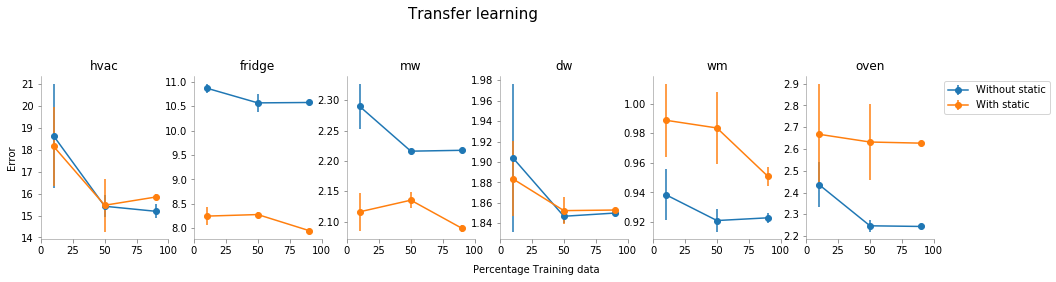

In [86]:
fig, ax = plt.subplots(ncols=6, figsize=(16, 3))
for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        
    none_results[appliance].plot(ax=ax[i], marker='o', label="Without static", title=appliance, yerr=none_results_err[appliance])
    ax[i].set_xlim(0, 100)
for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        
    static_results[appliance].plot(ax=ax[i], marker='o', label="With static", title=appliance, yerr=static_results_err[appliance])
    ax[i].set_xlim(0, 100)
    format_axes(ax[i])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[0].set_ylabel("Error")
fig.text(0.5, -0.03, "Percentage Training data")
plt.suptitle("Transfer learning", fontsize=15, y=1.2)

In [89]:
results = {'None':none_results, 'Static':static_results}
import pickle
pickle.dump(results, open("predictions/transfer_ada_static.pkl", 'w'))